## Imports

In [1]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [1]:
import os
import re
import spacy
import numpy as np
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models import KeyedVectors, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

## Data loading

In [2]:
filename = "boardgames_2000.csv"
df = pd.read_csv(filename, sep=";")
df.head()

,id,name,description,year,rating,complexity
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58832,4.3081
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.66358,1.9643
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47583,2.4420
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35050,2.4923


## Task 1: Text Preprocessing and vectorization

### Text Preprocessing

In [11]:
import pandas as pd
import re
import spacy

# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

custom_stopwords = {"s", "quot"}

def clean_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Apply spaCy NLP processing
    doc = nlp(text)

    # Remove stopwords, lemmatize, exclude punctuations, and custom words
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha and token.lemma_ not in custom_stopwords
    ]

    return " ".join(tokens)


In [12]:
# Apply the cleaning function to all descriptions
df["clean_description"] = df["description"].apply(clean_text)

In [13]:
# Example: original and cleaned text for first entry
print("Original:\n", df["description"][0])
print("Cleaned:\n", df["clean_description"][0])

Original:
 Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regional election and has some media influence in the region, then the party will receive some media-control victory points. Third, each party has a national party membership which will grow as the game progresses and this will supply a fair number of victory points. Lastly, parties score some victory points if their party platform matches the national opinions at the end of the game.&#10;&#10;The 1986 edition featured four parties from the old West Germany and

#### Save clean dataset (if desired)

In [ ]:
df.to_csv("boardgames_clean.csv", index=False, encoding="utf-8", sep=";")

### Vectorization

#### BoW and TF-IDF

In [14]:
# For this task, we will mainly be working with the column "clean_description".
# We will tokenize this part fist
tokenized_descr = [clean_description.split() for clean_description in df["clean_description"]]

In [15]:
# Then we will create a dictionary and obtain both the BoW corpus and the TF-IDF corpus
# BoW corpus
dictionary = corpora.Dictionary(tokenized_descr)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

# TF-IDF corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

Now we would like to obtain some insights from our data using the TF-IDF corpus. However, we cannot use it as it is. `tfidf_corpus`is a sparse corpus matrix, not a dense numpy matrix.

Gensim is optimized for streaming large corpora and if we wanted to do some visualizations, we would need to convert it to dense form.

In [16]:
num_docs = len(tfidf_corpus)
num_terms = len(dictionary)

# Create empty matrix
X_tfidf_gensim = np.zeros((num_docs, num_terms))

# Fill it with TF-IDF scores
for doc_idx, doc in enumerate(tfidf_corpus):
    for term_id, tfidf_score in doc:
        X_tfidf_gensim[doc_idx, term_id] = tfidf_score

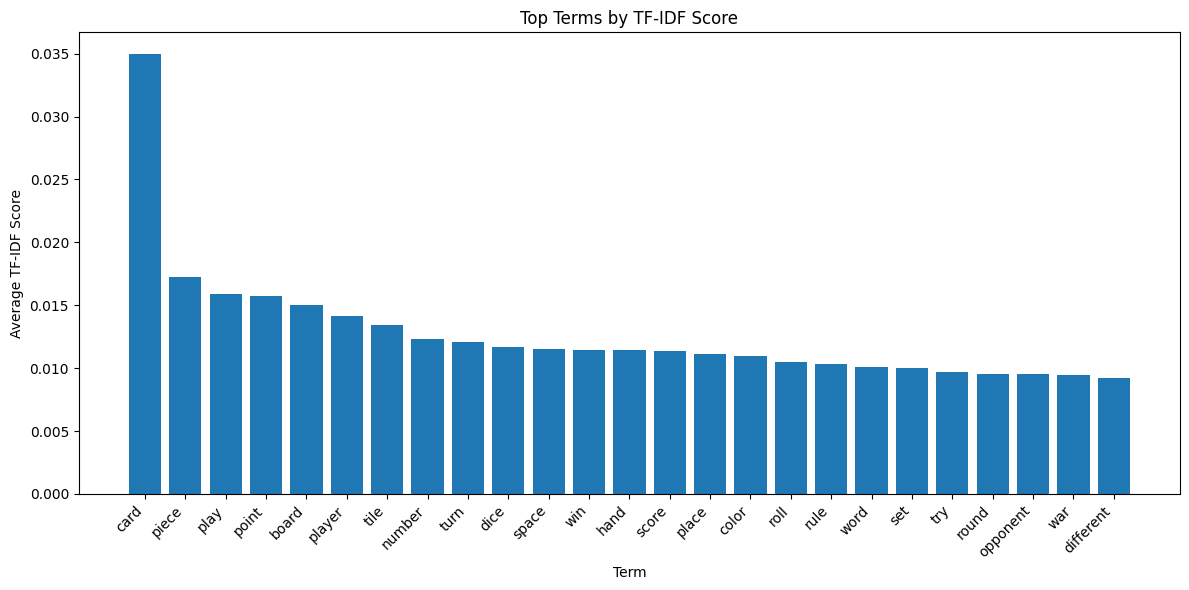

In [17]:
# Compute average TF-IDF per term
avg_tfidf_scores = X_tfidf_gensim.mean(axis=0)

# Top-N terms
top_n = 25
top_term_indices = avg_tfidf_scores.argsort()[::-1][:top_n]

# Get corresponding terms
terms = [dictionary[i] for i in top_term_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), avg_tfidf_scores[top_term_indices], tick_label=terms)
plt.xlabel('Term')
plt.ylabel('Average TF-IDF Score')
plt.title('Top Terms by TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

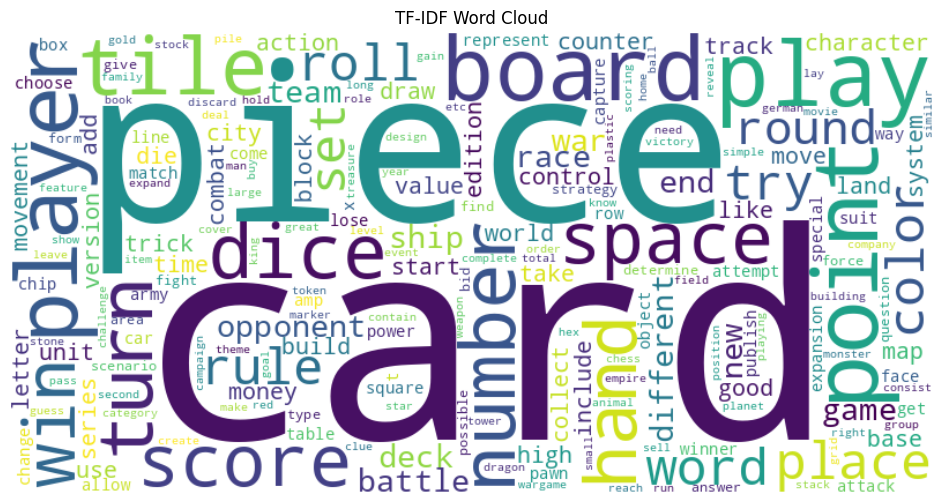

In [18]:
# Total TF-IDF score per term across all documents
tfidf_term_scores = X_tfidf_gensim.sum(axis=0)

# Map term to score
word_freq = {dictionary[i]: tfidf_term_scores[i] for i in range(num_terms)}

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_freq)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud')
plt.show()

#### GloVe and Doc2Vec

In [ ]:
# Load pretrained GloVe
w2v_model = gensim.downloader.load("glove-wiki-gigaword-100")

def get_avg_vector(doc):
    words = doc.split()
    vectors = [w2v_model[word] for word in words if word in w2v_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack(df["clean_description"].apply(get_avg_vector))

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# Prepare data
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df["clean_description"])]

# Train
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=40)

# Vectorize
X_doc2vec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

#### LDA

In [19]:
corpus = df['clean_description'].tolist()

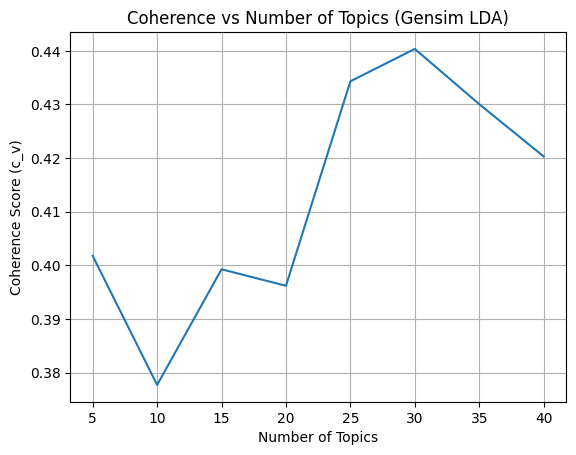

In [20]:
# Try different numbers of topics
coherence_scores = []
models = []
for k in range(5, 41, 5):
    model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=k, passes=15, random_state=42)
    coherence = CoherenceModel(model=model, texts=tokenized_descr, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence)
    models.append(model)

# Plot coherence vs. topic count
import matplotlib.pyplot as plt
plt.plot(range(5, 41, 5), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Number of Topics (Gensim LDA)")
plt.grid(True)
plt.show()

# Select best model
best_k = range(5, 41, 5)[np.argmax(coherence_scores)]
best_model = models[np.argmax(coherence_scores)]

In [21]:
for topic_id, words in best_model.show_topics(num_topics=best_k, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, prob in words]}")


Topic 0: ['cat', 'food', 'item', 'mouse', 'fish', 'job', 'coal', 'slow', 'factory', 'el']
Topic 1: ['game', 'party', 'box', 'edition', 'player', 'plastic', 'ant', 'match', 'mdash', 'pin']
Topic 2: ['car', 'race', 'track', 'game', 'player', 'horse', 'roll', 'line', 'dice', 'space']
Topic 3: ['city', 'train', 'german', 'railroad', 'building', 'build', 'rail', 'ingredient', 'rule', 'english']
Topic 4: ['game', 'german', 'player', 'b', 'series', 'x', 'counter', 'playing', 'rule', 'escape']
Topic 5: ['game', 'chess', 'board', 'castle', 'eacute', 'bowl', 'blood', 'king', 'animal', 'roman']
Topic 6: ['star', 'series', 'game', 'empire', 'munchkin', 'starship', 'different', 'fleet', 'base', 'inch']
Topic 7: ['card', 'player', 'play', 'game', 'hand', 'point', 'turn', 'win', 'deck', 'number']
Topic 8: ['island', 'pirate', 'temple', 'valley', 'expedition', 'treasure', 'disk', 'outlaw', 'adventure', 'lost']
Topic 9: ['character', 'game', 'card', 'player', 'power', 'monster', 'set', 'action', 'speci

In [22]:
beta_matrix = np.array(best_model.get_topics())
print("Beta shape:", beta_matrix.shape)

Beta shape: (30, 14530)


In [23]:
words = [dictionary[i] for i in range(len(dictionary))]

# We create a dataframe to read the results better
beta_df = pd.DataFrame(beta_matrix, columns=words, index=[f"Topic {i}" for i in range(best_k)])

# Here we display the top words per topic (beta vectors), with the probabilities.
for topic_id in range(best_k):
    print(f"\nTopic {topic_id}:")
    print(beta_df.iloc[topic_id].sort_values(ascending=False).head(10))



Topic 0:
cat        0.047880
food       0.043375
item       0.034009
mouse      0.023844
fish       0.020554
job        0.015704
coal       0.012576
slow       0.011310
factory    0.011259
el         0.009595
Name: Topic 0, dtype: float32

Topic 1:
game       0.027057
party      0.015831
box        0.014321
edition    0.012394
player     0.008747
plastic    0.007921
ant        0.007707
match      0.007512
mdash      0.007311
pin        0.007044
Name: Topic 1, dtype: float32

Topic 2:
car       0.052300
race      0.041824
track     0.040129
game      0.022556
player    0.021041
horse     0.019299
roll      0.018576
line      0.015184
dice      0.015067
space     0.012098
Name: Topic 2, dtype: float32

Topic 3:
city          0.027829
train         0.021769
german        0.019184
railroad      0.017313
building      0.016894
build         0.014532
rail          0.013140
ingredient    0.011012
rule          0.010993
english       0.010306
Name: Topic 3, dtype: float32

Topic 4:
game      

In [24]:
best_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

# igual usar esto que es más compacto


[(0,
  '0.048*"cat" + 0.043*"food" + 0.034*"item" + 0.024*"mouse" + 0.021*"fish" + 0.016*"job" + 0.013*"coal" + 0.011*"slow" + 0.011*"factory" + 0.010*"el"'),
 (1,
  '0.027*"game" + 0.016*"party" + 0.014*"box" + 0.012*"edition" + 0.009*"player" + 0.008*"plastic" + 0.008*"ant" + 0.008*"match" + 0.007*"mdash" + 0.007*"pin"'),
 (2,
  '0.052*"car" + 0.042*"race" + 0.040*"track" + 0.023*"game" + 0.021*"player" + 0.019*"horse" + 0.019*"roll" + 0.015*"line" + 0.015*"dice" + 0.012*"space"'),
 (3,
  '0.028*"city" + 0.022*"train" + 0.019*"german" + 0.017*"railroad" + 0.017*"building" + 0.015*"build" + 0.013*"rail" + 0.011*"ingredient" + 0.011*"rule" + 0.010*"english"'),
 (4,
  '0.030*"game" + 0.010*"german" + 0.009*"player" + 0.008*"b" + 0.008*"series" + 0.007*"x" + 0.007*"counter" + 0.006*"playing" + 0.006*"rule" + 0.006*"escape"'),
 (5,
  '0.034*"game" + 0.019*"chess" + 0.011*"board" + 0.010*"castle" + 0.009*"eacute" + 0.009*"bowl" + 0.009*"blood" + 0.009*"king" + 0.008*"animal" + 0.008*"roman

In [25]:
theta_matrix = []
for doc in bow_corpus:
    doc_topics = best_model.get_document_topics(doc, minimum_probability=0)
    theta_matrix.append([prob for _, prob in doc_topics])

theta_matrix = np.array(theta_matrix)
print("Theta shape:", theta_matrix.shape)


Theta shape: (2520, 30)


In [26]:
# Dataframe for the thetas
theta_df = pd.DataFrame(theta_matrix, columns=[f"Topic {i}" for i in range(best_k)])

# We just display the most relevant topic (the one with the highest probability)
theta_df["Dominant Topic"] = theta_df.idxmax(axis=1)

print(theta_df[["Dominant Topic"]])


     Dominant Topic
0           Topic 1
1           Topic 7
2          Topic 20
3          Topic 20
4           Topic 1
...             ...
2515        Topic 4
2516       Topic 13
2517       Topic 13
2518       Topic 20
2519        Topic 7

[2520 rows x 1 columns]


In [27]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.3 MB/s eta 0:00:00


In [28]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, bow_corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
20    -0.221294 -0.126211       1        1  19.506840
7     -0.248711 -0.165856       2        1  17.119773
17    -0.202814  0.080670       3        1  11.720041
13    -0.206962 -0.125989       4        1   5.139249
15    -0.140261  0.277384       5        1   5.112244
29    -0.189727  0.125674       6        1   4.629996
10    -0.159379  0.039403       7        1   4.216716
28    -0.146075  0.131810       8        1   3.925042
9     -0.155457  0.013271       9        1   3.829538
16    -0.163976 -0.174091      10        1   3.357385
4     -0.116685  0.144033      11        1   2.996378
5     -0.045665  0.041665      12        1   2.299069
2     -0.088333 -0.102143      13        1   2.080325
24     0.054919  0.053592      14        1   1.481707
19     0.024280 -0.085968      15        1   1.435757
1      0.022103  0.005810      16        1   1.303606
3      0.071568 -0.010088      17        1   1.281819
8      0.075459 -0.028027      18        1   1.194190
6      0.013260  0.118263      19        1   1.101450
18     0.075134 -0.099822      20        1   1.090646
11     0.015502 -0.119501      21        1   0.919615
21     0.156830 -0.032638      22        1   0.850201
14     0.171809  0.024015      23        1   0.708347
0      0.168920 -0.016434      24        1   0.686440
23     0.185613  0.011693      25        1   0.461575
22     0.205731 -0.011179      26        1   0.414671
26     0.195504  0.025639      27        1   0.379750
25     0.212052 -0.000548      28        1   0.362753
27     0.210053  0.001851      29        1   0.243414
12     0.226602  0.003722      30        1   0.151464, topic_info=              Term         Freq        Total Category  logprob  loglift
64            card  5311.000000  5311.000000  Default  30.0000  30.0000
377          piece   980.000000   980.000000  Default  29.0000  29.0000
14            game  6139.000000  6139.000000  Default  28.0000  28.0000
33          player  6898.000000  6898.000000  Default  27.0000  27.0000
149           tile   558.000000   558.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
2814          trap     0.862987    45.021567  Topic30  -5.8574   2.5381
997         battle     1.676754   581.187849  Topic30  -5.1932   0.6444
7832      entrance     0.427710     9.563625  Topic30  -6.5594   3.3853
1995      skeleton     0.254879     6.676299  Topic30  -7.0771   3.2270
9359  periodically     0.254879     1.653515  Topic30  -7.0771   4.6227

[1846 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
11411     22  0.799939      aa
10798     18  0.879599  abacus
590        1  0.289033    able
590        2  0.231226    able
590        3  0.202323    able
...      ...       ...     ...
1208      27  0.102300   young
11568     27  0.835134  zhukov
2801      11  0.817940  zombie
2801      12  0.148716  zombie
12631     26  0.595523  zucker

[4756 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 8, 18, 14, 16, 30, 11, 29, 10, 17, 5, 6, 3, 25, 20, 2, 4, 9, 7, 19, 12, 22, 15, 1, 24, 23, 27, 26, 28, 13])

ADDING A NEW VARIABLE DEPENDING ON TONE

In [50]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm

labels = [
    "funny", "dark", "serious", "scary", "happy", "family-friendly", "intense"
]

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def classify_tone(description):
    result = classifier(description, labels)
    # Return the top label
    return result['labels'][0]

tqdm.pandas()
df["predicted_tone"] = df["clean_description"].progress_apply(classify_tone)

print(df[["name", "predicted_tone"]].head())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 2520/2520 [10:27<00:00,  4.02it/s]


             name predicted_tone
0      Die Macher        serious
1    Dragonmaster        serious
2         Samurai        intense
3  Tal der Könige          happy
4         Acquire        serious


In [51]:
num_examples = 100
for i in range(num_examples):
    print(f"\n Game: {df.iloc[i]['name']}")
    print(f" Description:\n{df.iloc[i]['clean_description'][:500]}...")
    print(f" Predicted Tone: {df.iloc[i]['predicted_tone']}")



 Game: Die Macher
 Description:
die macher game seven sequential political race different region germany player charge national political party manage limited resource help party victory win party victory point regional election different way scoring victory point regional election supply eighty victory point depend size region party second party win regional election medium influence region party receive medium control victory point party national party membership grow game progress supply fair number victory point lastly par...
 Predicted Tone: serious

 Game: Dragonmaster
 Description:
dragonmaster trick taking card game base old game call coup d tat player give supply plastic gem represent point player dealer different hand slightly different goal hand card deal dealer decide hand good suit current card player penalize point form crystal take certain trick card instance call player penalize take trick player chance dealer hand player steal opportunity take trick certain hand end b

REGRESSION TO PREDICT RATING

Just with metadata complexity and year

In [64]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Select only the 'complexity' and 'year' columns
X_metadata = df[["complexity", "year"]].values

# Target variable y
y = df["rating"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_metadata, y, test_size=0.2, random_state=42)

# Train a DecisionTree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")



Test MSE: 1.1793


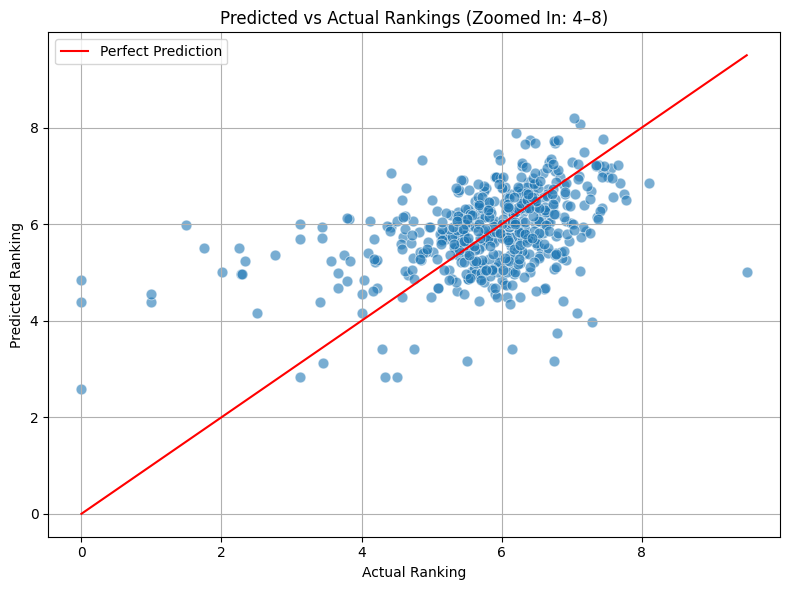

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Just with description embedded

In [66]:
import pandas as pd
import numpy as np
import re
import html
import spacy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Load GloVe embeddings
def load_glove_embeddings(filepath="glove.6B.100d.txt"):
    embeddings = {}
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Convert a description to a GloVe vector
def get_glove_vector(text, glove, dim=100):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)


glove = load_glove_embeddings("glove.6B.100d.txt")


df["glove_vector"] = df["clean_description"].apply(lambda x: get_glove_vector(x, glove))

# Stack into matrix
X = np.vstack(df["glove_vector"].values)
y = df["rating"]  # Change this to your target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")


Test MSE: 1.1687


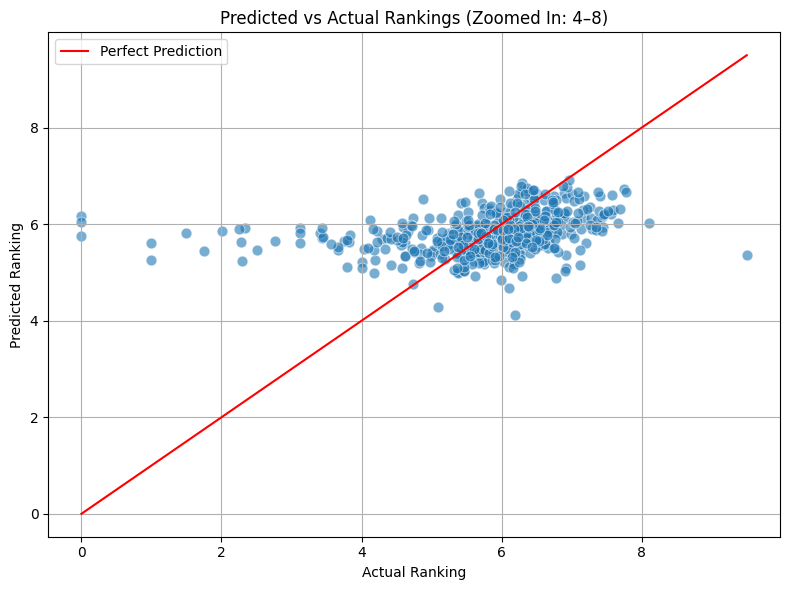

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now we use the other metadata complexity and year

In [48]:
X_text = np.vstack(df["glove_vector"].values)
X_metadata = df[["complexity", "year"]].values
X = np.hstack([X_text, X_metadata])


y = df["rating"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")


Test MSE: 0.9093


It actually improves with the combination of the two

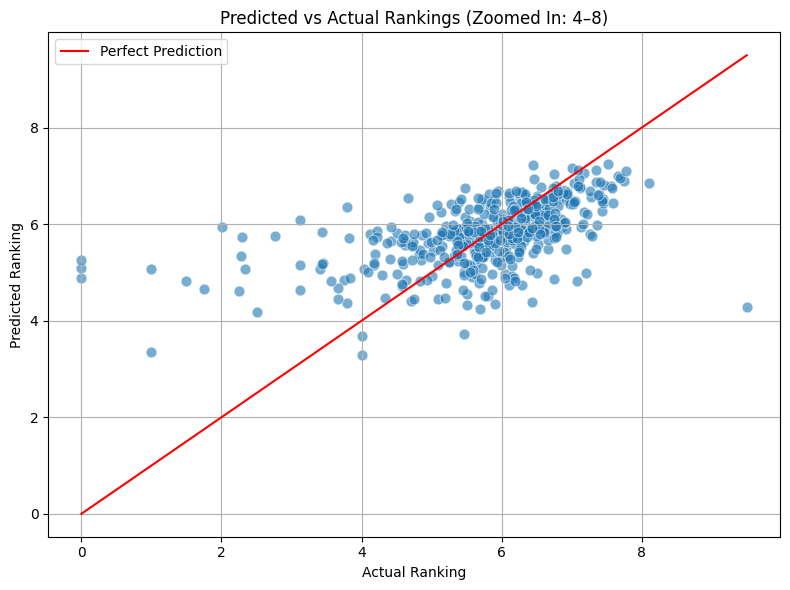

In [49]:
# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now let's try with the tone predicted

In [54]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Create feature matrix X (including 'complexity', 'year' and 'predicted_tone' along with GloVe vectors)
X_text = np.vstack(df["glove_vector"].values)
X_metadata = df[["complexity", "year"]].values

# One-hot encode 'predicted_tone' if it's categorical
encoder = OneHotEncoder(drop='first')  # Drop first category to avoid multicollinearity
predicted_tone_encoded = encoder.fit_transform(df[["predicted_tone"]]).toarray()

# Combine all features
X = np.hstack([X_text, X_metadata, predicted_tone_encoded])

# Target variable y
y = df["rating"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and calculate MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")



Test MSE: 0.8936


It doesn't really improve much

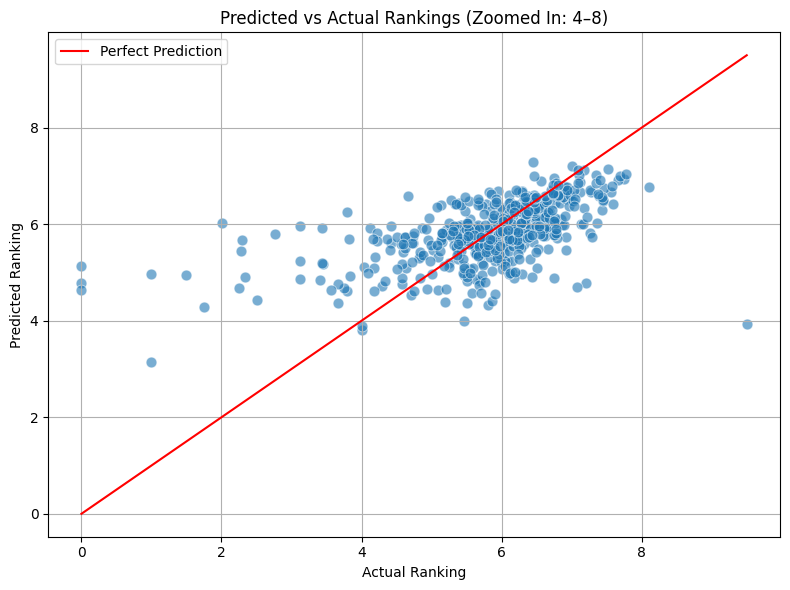

In [55]:
# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=60)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Ranking")
plt.ylabel("Predicted Ranking")
plt.title("Predicted vs Actual Rankings (Zoomed In: 4–8)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


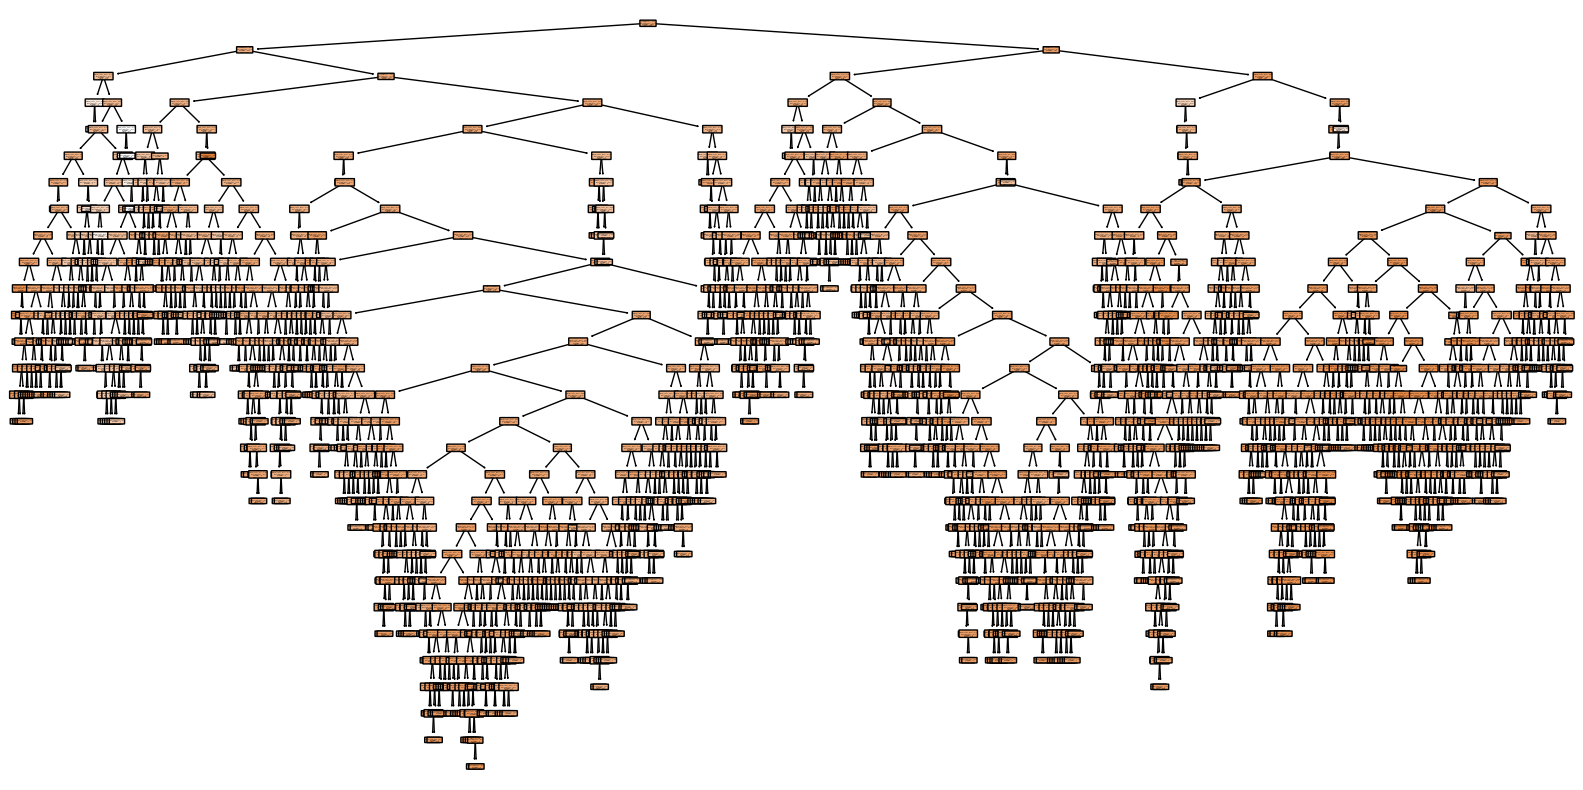

In [62]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], filled=True, feature_names=["glove_vector_" + str(i) for i in range(X_text.shape[1])] + ["complexity", "year"] + encoder.categories_[0].tolist(), class_names=["rating"], rounded=True, proportion=False, precision=2)
plt.show()

# qué barbaridad